In [0]:
from singlestep import *

from math import sqrt
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import mean_squared_error
from keras.layers import Dense,LSTM,Bidirectional,BatchNormalization,Dropout,Conv1D,GRU,MaxPooling1D
from keras.models import Sequential,Model
from keras.layers.merge import concatenate
from keras.callbacks import History, ModelCheckpoint
from keras import optimizers
from keras.engine.input_layer import Input
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#training on 2.6 years and testing on 4 months 

def n_split(data):  #CORRECT
    train,test=data[0:24*365*2+24*30*6],data[24*365*2+24*30*6:24*365*3]
    train=np.split(train,len(train)/24)
    test=np.split(test,len(test)/24)
    return np.array(train),np.array(test)

In [0]:
#feature_selection using xgboost to know about important features 

def feature_selection(train,test):
  X_train,Y_train= train[0:24*365*2+24*30*6,1:],train[0:24*365*2+24*30*6,0]
  X_test,Y_test = test[:,1:], test[:,0]
  reg = xgb.XGBRegressor(n_estimators=1000)
  reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        early_stopping_rounds=50,verbose=False) 
  xgb.plot_importance(reg, height=0.9)

In [0]:
def main():

  
    data=pd.read_csv('/content/Delhi_Hourly.csv',header=0,parse_dates=True,index_col=[0])

    data=data.reindex(columns=["Ozone","year","month","day","hour","PM10","BP","SR","NH3","NOx","NO","NO2","PM2.5","SO2","CO"]) #target variable Ozone
    n_input=8        #setting the time lag parameter to 8
    #saving min and max for denormalization
    min=data['Ozone'].min()   
    max=data['Ozone'].max()   

    #normalizing parameters 

    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
      
    
    feature_selection(data[0:24*365*2+24*30*6],data[24*365*2+24*30*6:24*365*3])
    train,test=n_split(data)
    print(train.shape)
    print(test.shape)
    train_x,train_y=to_supervised(train,n_input,1)
    n_timesteps,n_features,n_outputs=train_x.shape[1],train_x.shape[2],train_y.shape[1]
    print(train_x.shape)
    print(train_y.shape)

    model=CNN_GRU(n_timesteps)
    history = fit_model(train_x,train_y,model,0,0)
    scores,final_score= model_eval(train,test,n_input,model,24,0)
    scores=[t*(max-min)+min for t in scores]
    print(scores)
    print(final_score*(max-min)+min)

    #saving the model

    filename = 'modeldelhiOzone.sav'
    pickle.dump(model, open(filename, 'wb'))
    os.remove('/content/best_weights0.hdf5')
   



[04:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(910, 24, 15)
(185, 24, 15)
(21832, 8, 15)
(21832, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8, 1)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 8, 1)         0                                            
__________________________________________________________________________________________________
input_4 (I

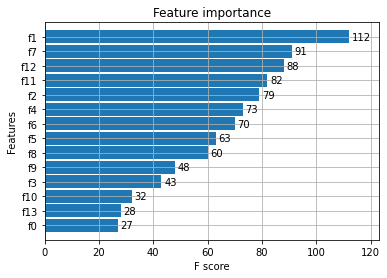

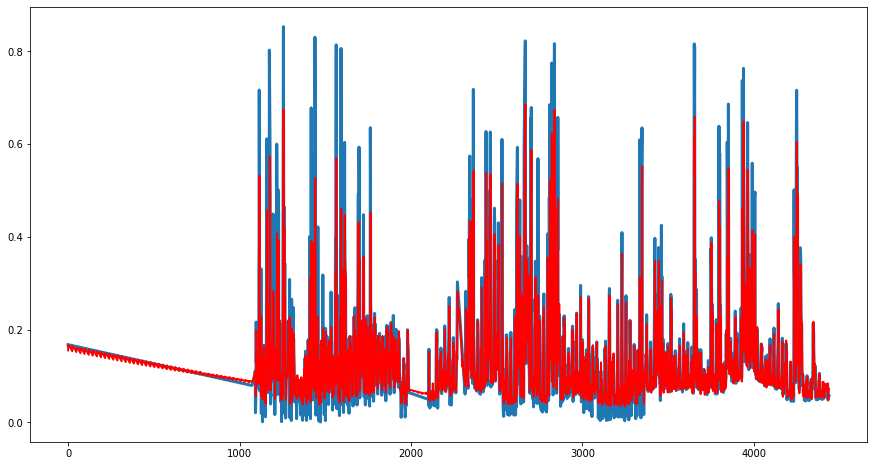

[18.496734552449286, 13.630309394654208, 14.427107128677479, 12.828244023436499, 15.545490944525337, 21.817050642553596, 12.739223035697513, 13.700555613970673, 18.5348673248134, 12.794031036798568, 14.449291608140463, 17.66013008901243, 13.245907596165148, 15.614804776086885, 10.255548694573436, 11.642485865088995, 10.683386094068638, 17.576746183157763, 12.54547637805175, 9.256368314246275, 14.109776044516726, 15.054458516972018, 17.800569177769987, 14.597049567606996]
14.82952040756379


In [0]:
if __name__=='__main__':
  main()